In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

from torchvision import datasets, transforms
from sklearn.base import BaseEstimator
from sklearn import model_selection
from sklearn.model_selection import ShuffleSplit, learning_curve

# 1. Data Visualization

In [2]:
data_transform = transforms.Compose([lambda img: transforms.functional.rotate(img, -90),
                                transforms.RandomHorizontalFlip(p=1),
                                transforms.ToTensor()
                            ])
data = datasets.EMNIST(
    root="~/data",
    split="balanced",
    download=False,
    transform=data_transform
)

def get_data(data, indices=None, binarize=True):
  N = len(data)
  if indices is None:
    indices = range(0, N)
  X = np.stack([data[i][0].numpy() for i in indices], axis=1).squeeze(0) # (N,28,28)
  if binarize: 
    X = (X > 0.5)
  y = np.array([data[i][1] for i in indices])
  return X, y

X, y = get_data(data)

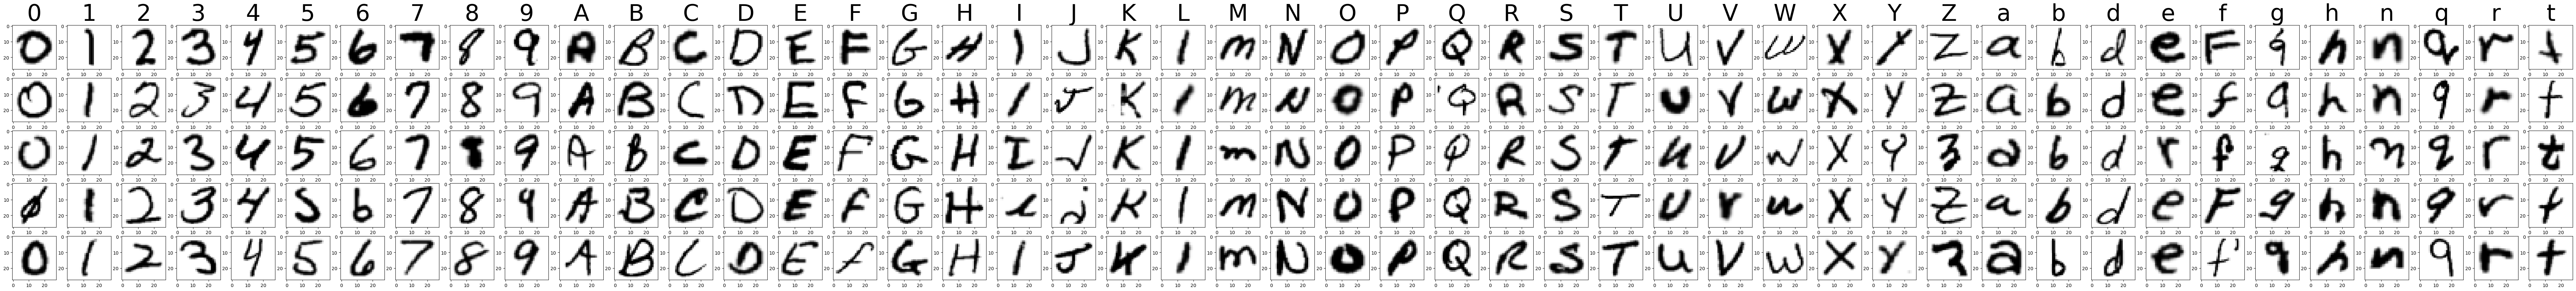

In [26]:
rows = 5
columns = len(data.classes)
fig = plt.figure(figsize = (100, 10))

for i in range(columns):
    class_index = [j for j in range(len(y)) if y[j] == i]
    sampled_imgs = random.sample(class_index, 5)
    for k in range(rows):
        index = sampled_imgs[k]
        img, label = data[index]
        fig.add_subplot(rows, columns, columns * k + (i + 1))
        label = data.classes[label]
        if k == 0:
            plt.title(label, fontsize = 50)
        plt.imshow(img.squeeze(), cmap = plt.cm.binary)
plt.show()

# 2. Scikit Estimators

## 2.1 Maximum Likelihood Estimator

In [4]:
class NaiveBayesMLE(BaseEstimator):
    def __init__(self):
        self.labels = None
        self.num_labels = 0
        self.num_features = 0
        self.P_xy = None
        self.P_y = None
        self.min_prob = 1e-12

    def __compute_P_y(self, y):
        self.P_y = np.array([max(len(y[y == index]) / len(y), self.min_prob) for index in range(self.num_labels)])

    def __compute_P_xy(self, X, y):
        for label_index in range(self.num_labels):
            x_label = X[np.nonzero(y == label_index)]
            for feat_index in range(self.num_features):
                success = len(x_label[np.where(x_label[:, feat_index // X.shape[1], feat_index % X.shape[1]] == True)])
                prob = max(success / (len(x_label) + 1e-8), self.min_prob)
                self.P_xy[feat_index][label_index] = prob

    def fit(self, X, y):
        self.labels = np.unique(y)
        self.num_labels = len(self.labels)
        self.num_features = X.shape[1] * X.shape[2]

        self.__compute_P_y(y)
        
        self.P_xy = np.zeros((self.num_features, self.num_labels)) # Shape (784 * 47)
        self.__compute_P_xy(X, y)


    def predict(self, X):
        y_pred = []
        for img in X:
            log_likelhoods = []
            for label_index in range(47):
                log_likelihood = np.log(self.P_y[label_index])
                for feat_index in range(self.num_features):
                    if img[feat_index // img.shape[0], feat_index % img.shape[0]]:
                        log_likelihood += np.log(self.P_xy[feat_index][label_index])
                    else:
                        log_likelihood += np.log(1 - self.P_xy[feat_index][label_index])
                log_likelhoods.append(log_likelihood)
            y_pred.append(np.argmax(log_likelihood))
        return y_pred


    def score(self, X, Y):
        score = 0
        for index in range(self.num_labels):
            log_likelihood = 0
            x_label = X[np.nonzero(Y == index)]
            x_label_length = len(x_label)
            try:
                for feature_index in range(X.shape[1] * X.shape[2]):
                    success = len(x_label[np.where(x_label[ : , feature_index // 28, feature_index % 28] == True)])
                    prob = self.P_xy[feature_index][index]
                    log_likelihood += success * np.log(prob) + (x_label_length - success) * np.log((1 - prob))
                score += log_likelihood + x_label_length * np.log(self.P_y[index])
            except:
                score += log_likelihood
        return score / len(X)

## 2.2 Maximum A-Posteriori Estimator

In [5]:
class NaiveBayesMAP(BaseEstimator):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.labels = None
        self.num_labels = 0
        self.num_features = 0
        self.P_xy = None
        self.P_y = None
        self.min_prob = 1e-12

    def __compute_P_y(self, y):
        self.P_y = np.array([
            max((self.alpha - 1 + len(y[y == index])) / (self.num_labels * self.alpha - self.num_labels + len(y)), self.min_prob) 
            for index in range(self.num_labels)
        ])

    def __compute_P_xy(self, X, y):
        for label_index in range(self.num_labels):
            x_label = X[np.nonzero(y == label_index)]
            for feat_index in range(self.num_features):
                success = len(x_label[np.where(x_label[:, feat_index // X.shape[1], feat_index % X.shape[1]] == True)])
                prob = max((self.beta - 1 + success) / (self.beta * 2 - 2 + len(x_label) + 1e-8), self.min_prob)
                self.P_xy[feat_index][label_index] = prob

    def fit(self, X, y):
        self.labels = np.unique(y)
        self.num_labels = len(self.labels)
        self.num_features = X.shape[1] * X.shape[2]

        self.__compute_P_y(y)
        
        self.P_xy = np.zeros((self.num_features, self.num_labels)) # Shape (784 * 47)
        self.__compute_P_xy(X, y)


    def predict(self, X):
        y_pred = []
        for img in X:
            log_likelhoods = []
            for label_index in range(47):
                log_likelihood = np.log(self.P_y[label_index])
                for feat_index in range(self.num_features):
                    if img[feat_index // img.shape[0], feat_index % img.shape[0]]:
                        log_likelihood += np.log(self.P_xy[feat_index][label_index])
                    else:
                        log_likelihood += np.log(1 - self.P_xy[feat_index][label_index])
                log_likelhoods.append(log_likelihood)
            y_pred.append(np.argmax(log_likelihood))
        return y_pred


    def score(self, X, Y):
        score = 0
        for index in range(self.num_labels):
            log_likelihood = 0
            x_label = X[np.nonzero(Y == index)]
            x_label_length = len(x_label)
            try:
                for feature_index in range(X.shape[1] * X.shape[2]):
                    success = len(x_label[np.where(x_label[ : , feature_index // 28, feature_index % 28] == True)])
                    prob = self.P_xy[feature_index][index]
                    log_likelihood += success * np.log(prob) + (x_label_length - success) * np.log((1 - prob))
                score += log_likelihood + x_label_length * np.log(self.P_y[index])
            except:
                score += log_likelihood
        return score / len(X)

# 3. Learning Curves for (almost) Balanced Training Data

In [6]:
def plot_learning_curve(estimator, title, X, y, axes = None, ylim = None, cv = None, n_jobs = None, scoring = None,
                        train_sizes = np.linspace(0.1, 1.0, 5),):
    if axes is None:
        _, axes = plt.subplots(figsize = (5, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training samples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, scoring = scoring, cv = cv,
                                                                          n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                      alpha = 0.1, color = "r",)
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                      alpha = 0.1, color = "g",)
    
    axes.plot(train_sizes, train_scores_mean, "o-", color = "r", label = "Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color = "g", label = "Cross-validation score")
    axes.legend(loc = "best")
    return plt

## 3.1 MLE

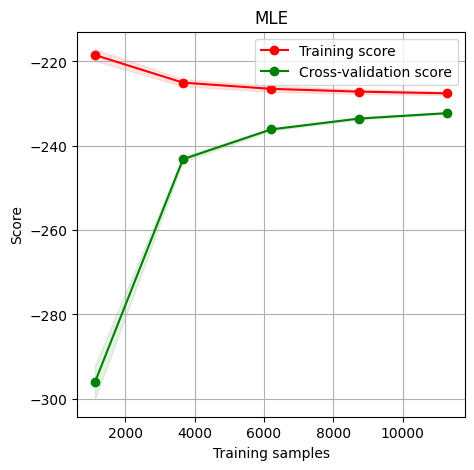

In [7]:
plot_learning_curve(NaiveBayesMLE(), title=f"MLE", 
                        X = X, y = y, axes = None, 
                        cv = ShuffleSplit(n_splits = 12, test_size = .9, random_state = 0), n_jobs = -1).show()

## 3.2 MAP varying alpha

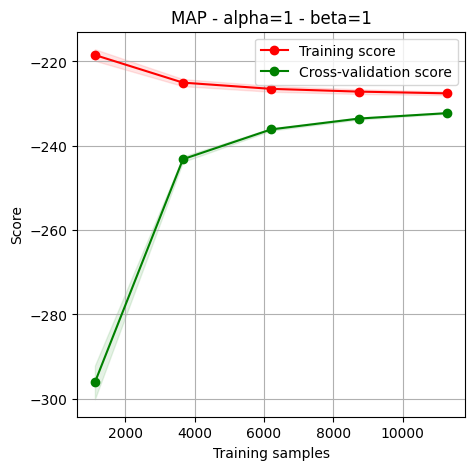

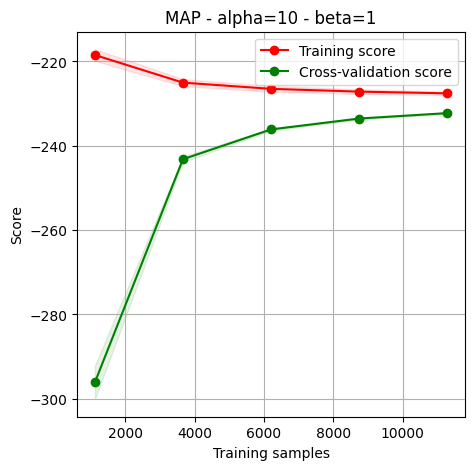

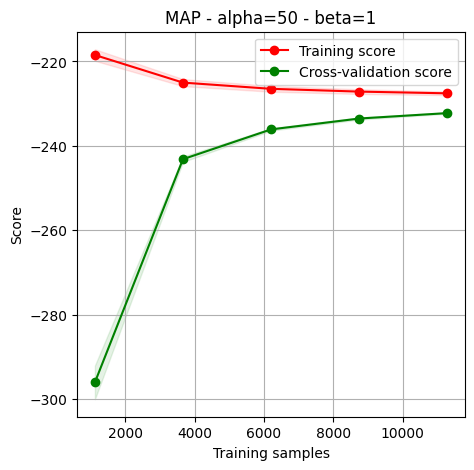

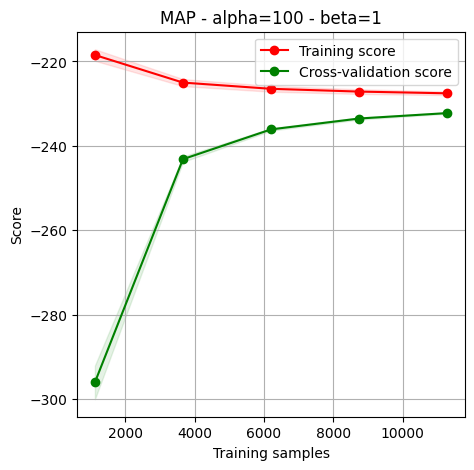

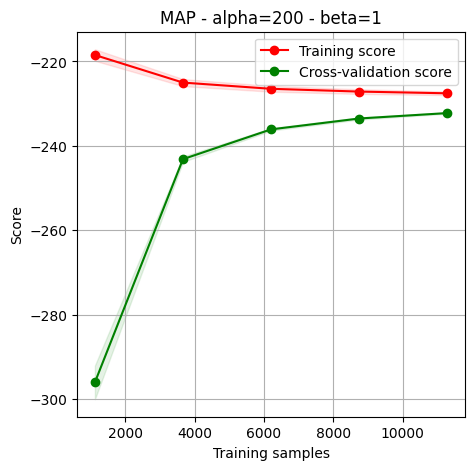

In [8]:
for alpha in [1, 10, 50, 100, 200]:
    plot_learning_curve(NaiveBayesMAP(alpha=alpha, beta=1), title=f"MAP - alpha={alpha} - beta=1", 
                        X = X, y = y, axes = None, 
                        cv = ShuffleSplit(n_splits = 12, test_size = .9, random_state = 0), n_jobs = -1).show()

## 3.3 MAP varying beta

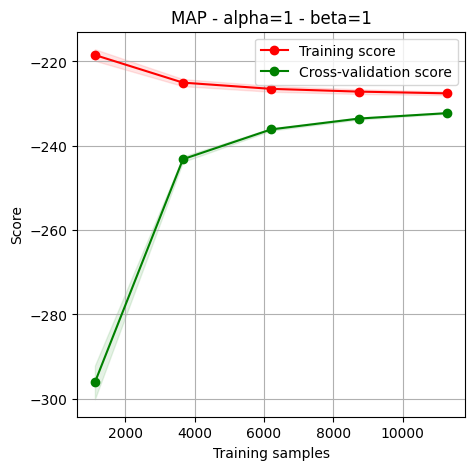

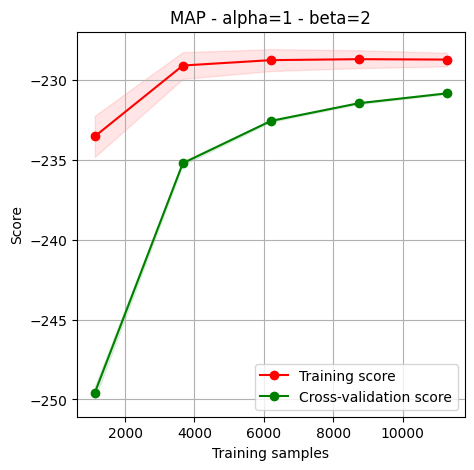

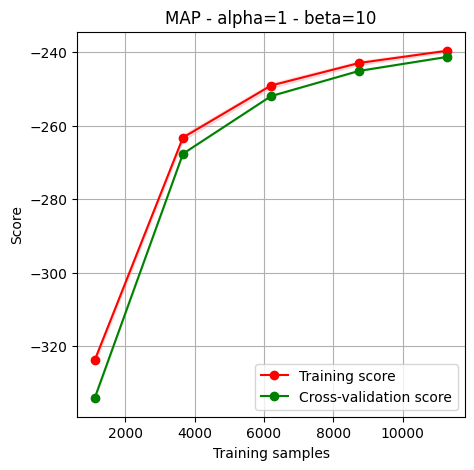

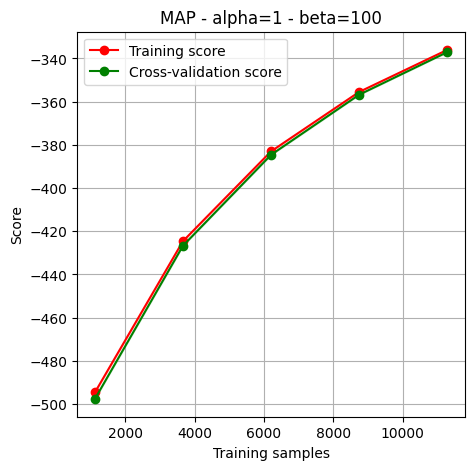

In [9]:
for beta in [1, 2, 10, 100]:
    plot_learning_curve(NaiveBayesMAP(alpha=1, beta=beta), title=f"MAP - alpha=1 - beta={beta}", 
                        X = X, y = y, axes = None, 
                        cv = ShuffleSplit(n_splits = 12, test_size = .9, random_state = 0), n_jobs = -1).show()

# 4. Learning Curves for Imbalanced Training Data

In [11]:
from sklearn.model_selection._split import BaseShuffleSplit, _validate_shuffle_split, check_random_state
from sklearn.utils.validation import _num_samples

class CustomShuffleSplit(BaseShuffleSplit):
    def __init__(self, n_splits=10, *, test_size=None, train_size=None, random_state=None, y=None, alpha_class=None):
        super().__init__(
            n_splits=n_splits,
            test_size=test_size,
            train_size=train_size,
            random_state=random_state,
        )
        self._default_test_size = 0.1
        self._y = y
        self._alpha_class = alpha_class

    def _imbalanced_sampling(train_indices, y, alpha_class):
        y_train = y[train_indices]
        class_freq_dict = Counter(y_train)
        dist = (np.random.dirichlet([alpha_class] * 47 , 1) * train_indices.shape[0]).astype(int).flatten()
        dist[dist == 0] = np.random.choice([1, 2, 3])
        for index, item in enumerate(dist):
            if dist[index] > class_freq_dict[index]:
                dist[index] = class_freq_dict[index]
        label_index_dict = {}
        for index, label in enumerate(y_train):
            label_index_dict[label] = label_index_dict.get(label, []) + [index]
        sampled_indices = []
        for label, num_samples in enumerate(dist):
            sampled_indices.extend(random.sample(label_index_dict[label], num_samples))
        return sampled_indices

    def _iter_indices(self, X, y=None, groups=None):
        n_samples = _num_samples(X)
        n_train, n_test = _validate_shuffle_split(
            n_samples,
            self.test_size,
            self.train_size,
            default_test_size=self._default_test_size,
        )

        rng = check_random_state(self.random_state)
        for i in range(self.n_splits):
            # random partition
            permutation = rng.permutation(n_samples)
            ind_test = permutation[:n_test]
            ind_train = permutation[n_test : (n_test + n_train)]
            ind_train = self._imbalanced_sampling(train_indices=ind_train, y=self._y, alpha_class=self._alpha_class)
            yield ind_train, ind_test

In [12]:
def get_learning_curve_results(estimator, X, y, n_splits):
    alpha_class = [0.1, 0.2, 0.5, 1, 10, 100]
    results = {}
    for a_c in alpha_class:
        train_sizes, train_scores, test_scores = learning_curve(
                                                    estimator, 
                                                    X, 
                                                    y, 
                                                    scoring = None, 
                                                    cv = CustomShuffleSplit(n_splits=n_splits, test_size=.9, random_state=0, y=y, alpha_class=a_c),
                                                    n_jobs = -1, 
                                                    train_sizes = np.linspace(0.1, 1.0, 5)
                                                )
        train_scores_mean = np.mean(train_scores, axis = 1)
        train_scores_std = np.std(train_scores, axis = 1)
        test_scores_mean = np.mean(test_scores, axis = 1)
        test_scores_std = np.std(test_scores, axis = 1)
        results[a_c] = [train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std]
    return results

In [13]:
def generate_learning_curve_plots(results, title):
    _, axes = plt.subplots(1, 6, figsize = (33, 5))

    for index, (alpha_class, result) in enumerate(results.items()):
        train_sizes, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std = result
        axes[index].set_title(f"{title} - alpha_class={alpha_class}")
        axes[index].set_xlabel("Training samples")
        axes[index].set_ylabel("Score")
        axes[index].grid()
        axes[index].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std,
                          alpha = 0.1, color = "r",)
        axes[index].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std,
                          alpha = 0.1, color = "g",)

        axes[index].plot(train_sizes, train_scores_mean, "o-", color = "r", label = "Training score")
        axes[index].plot(train_sizes, test_scores_mean, "o-", color = "g", label = "Cross-validation score")
        axes[index].legend(loc = "lower right")
    

## 4.1 MLE:
#### alpha_class = [0.1, 0.2, 0.5, 1, 10, 100]

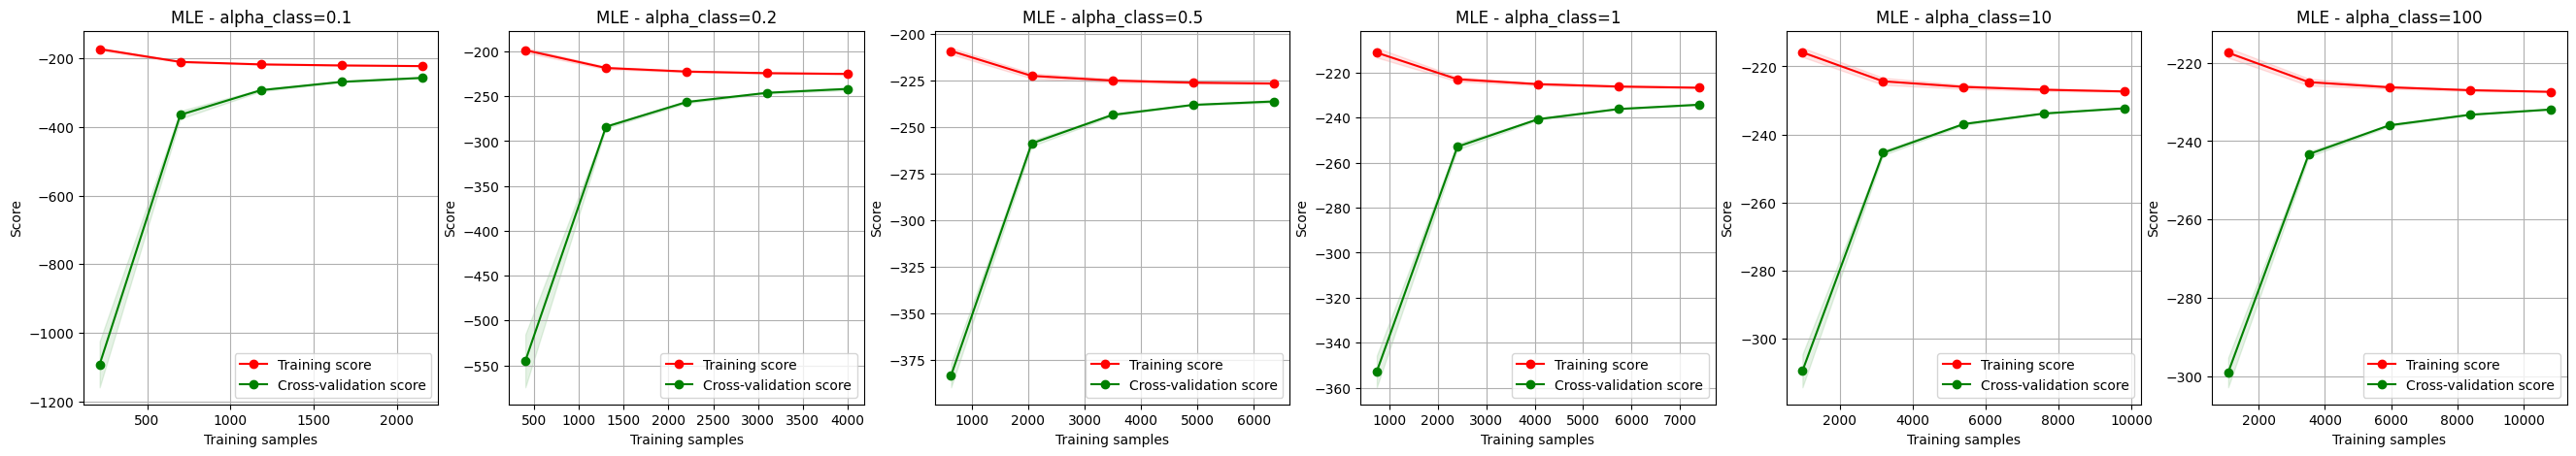

In [14]:
results = get_learning_curve_results(NaiveBayesMLE(), X, y, 12)
generate_learning_curve_plots(results, title=f"MLE")

## 4.2 MAP varying alpha: 
#### alpha = [1, 10, 100, 1000], beta = 1, alpha_class = [0.1, 0.2, 0.5, 1, 10, 100]

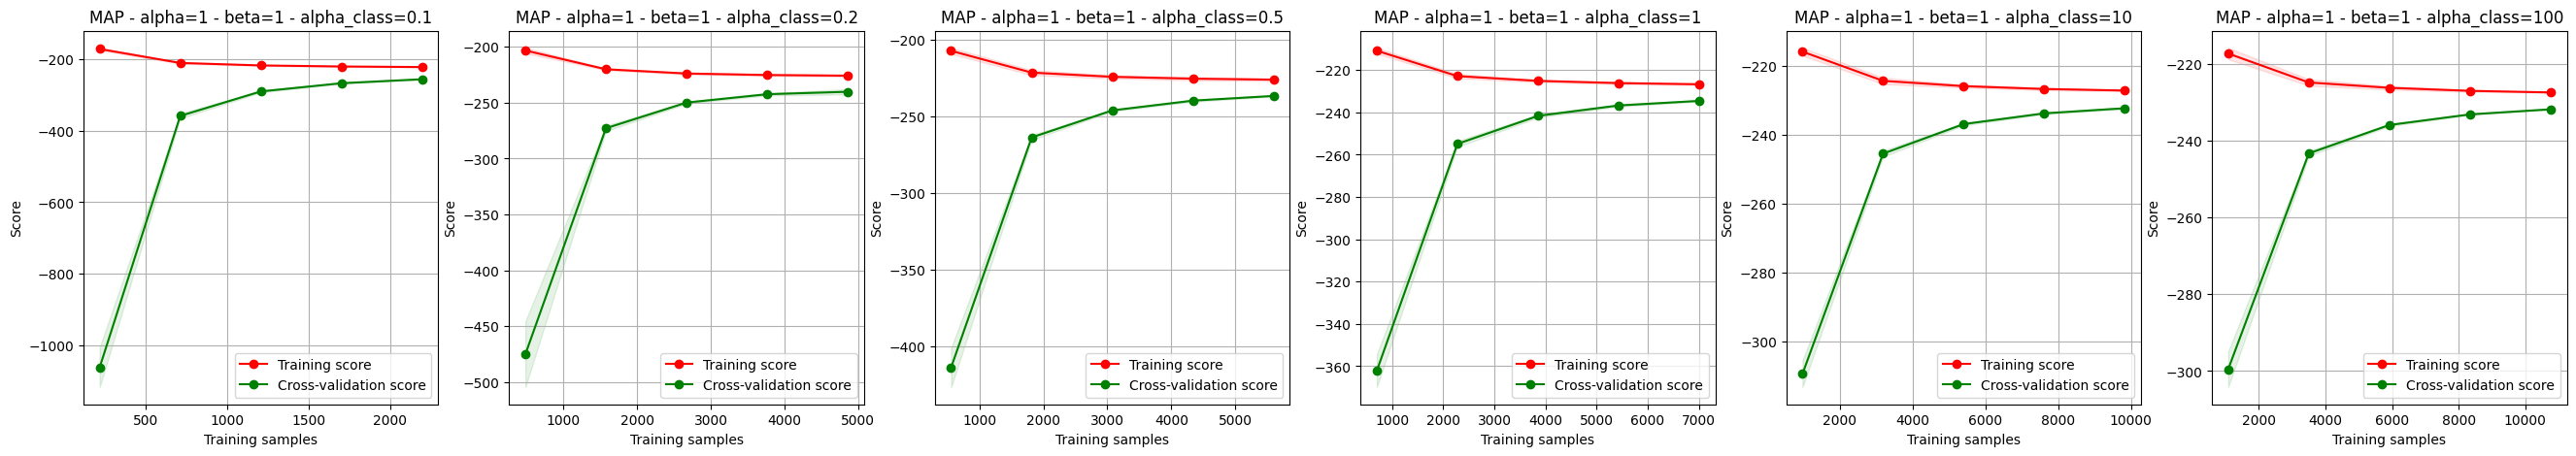

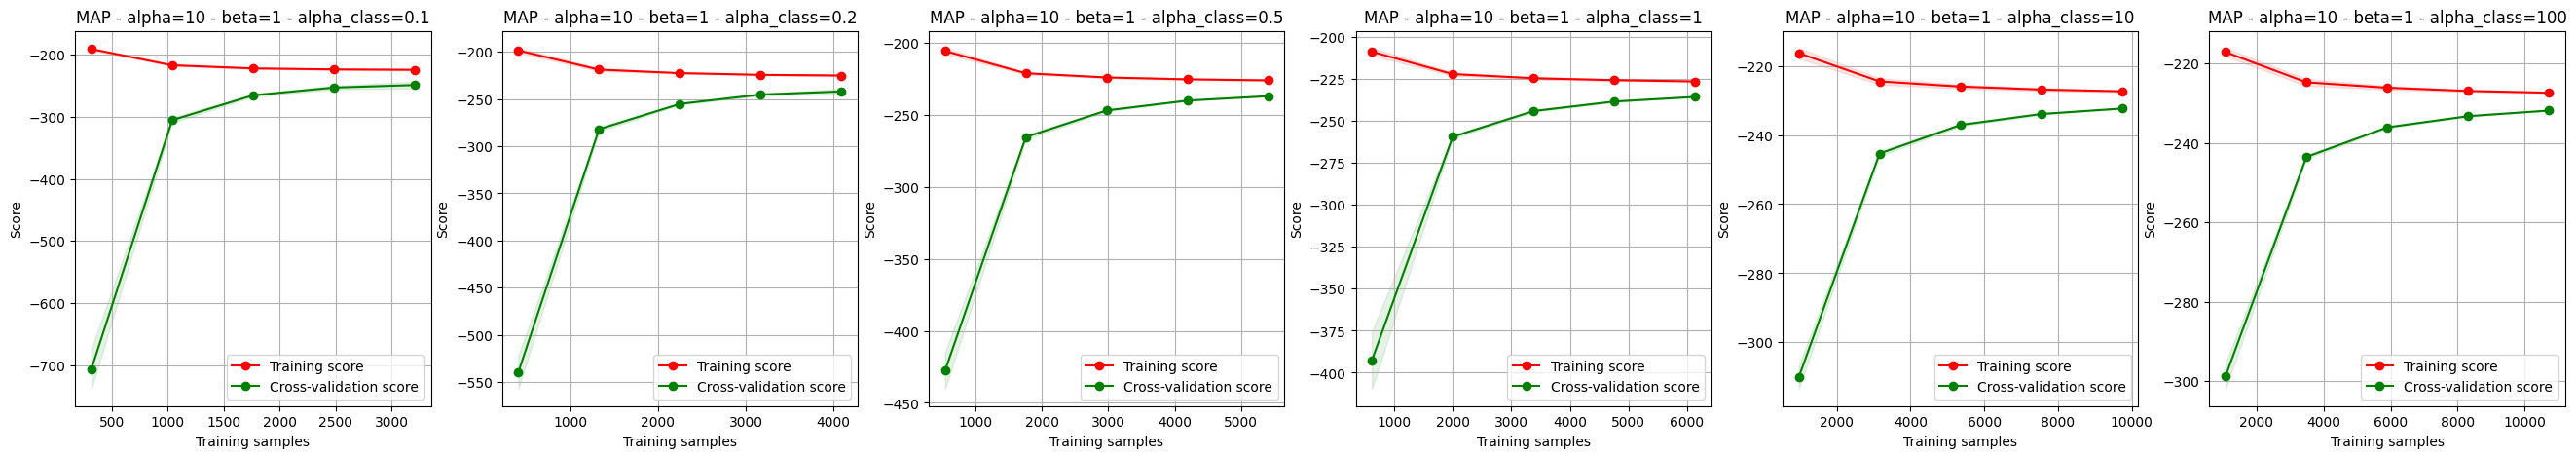

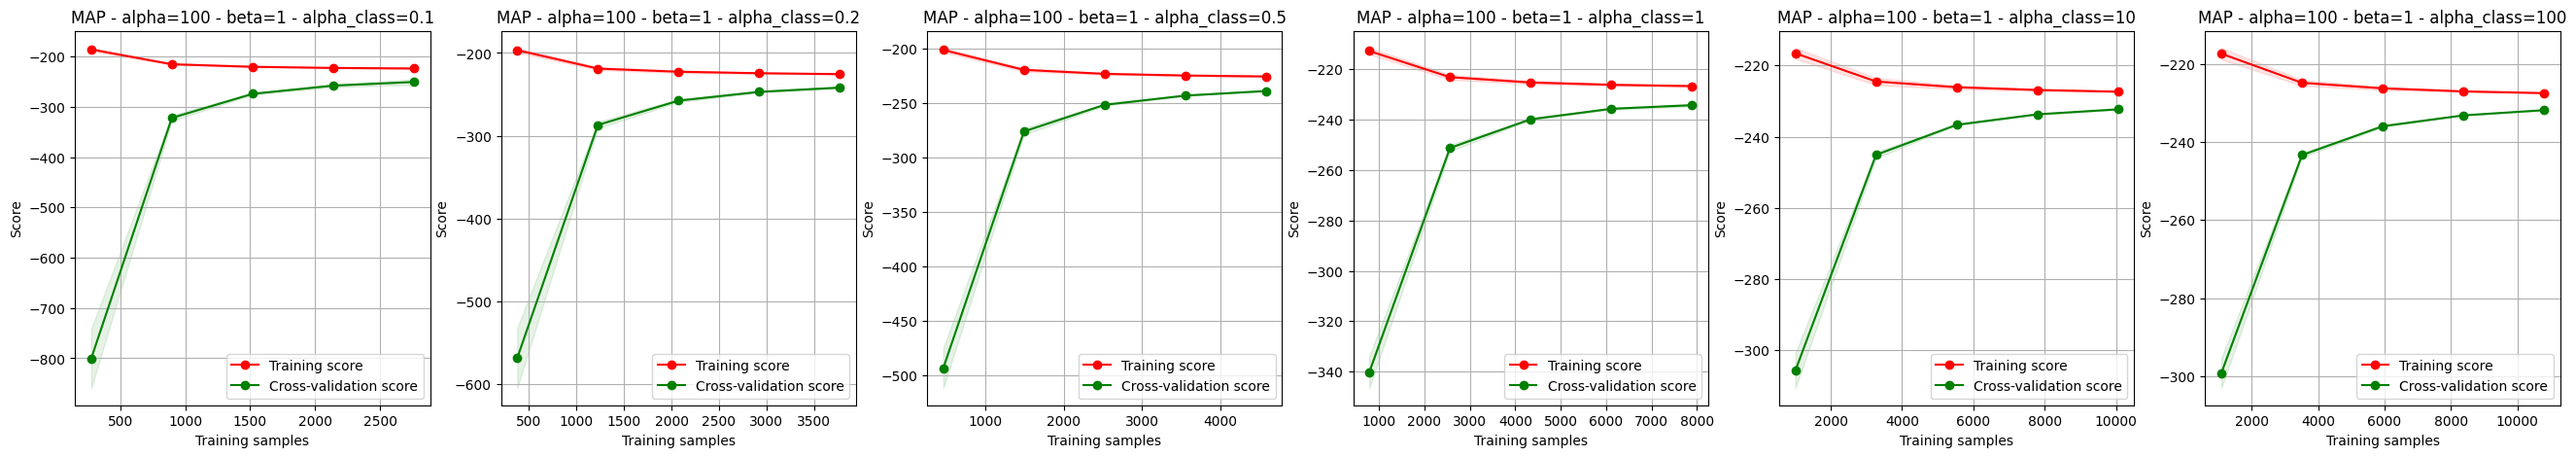

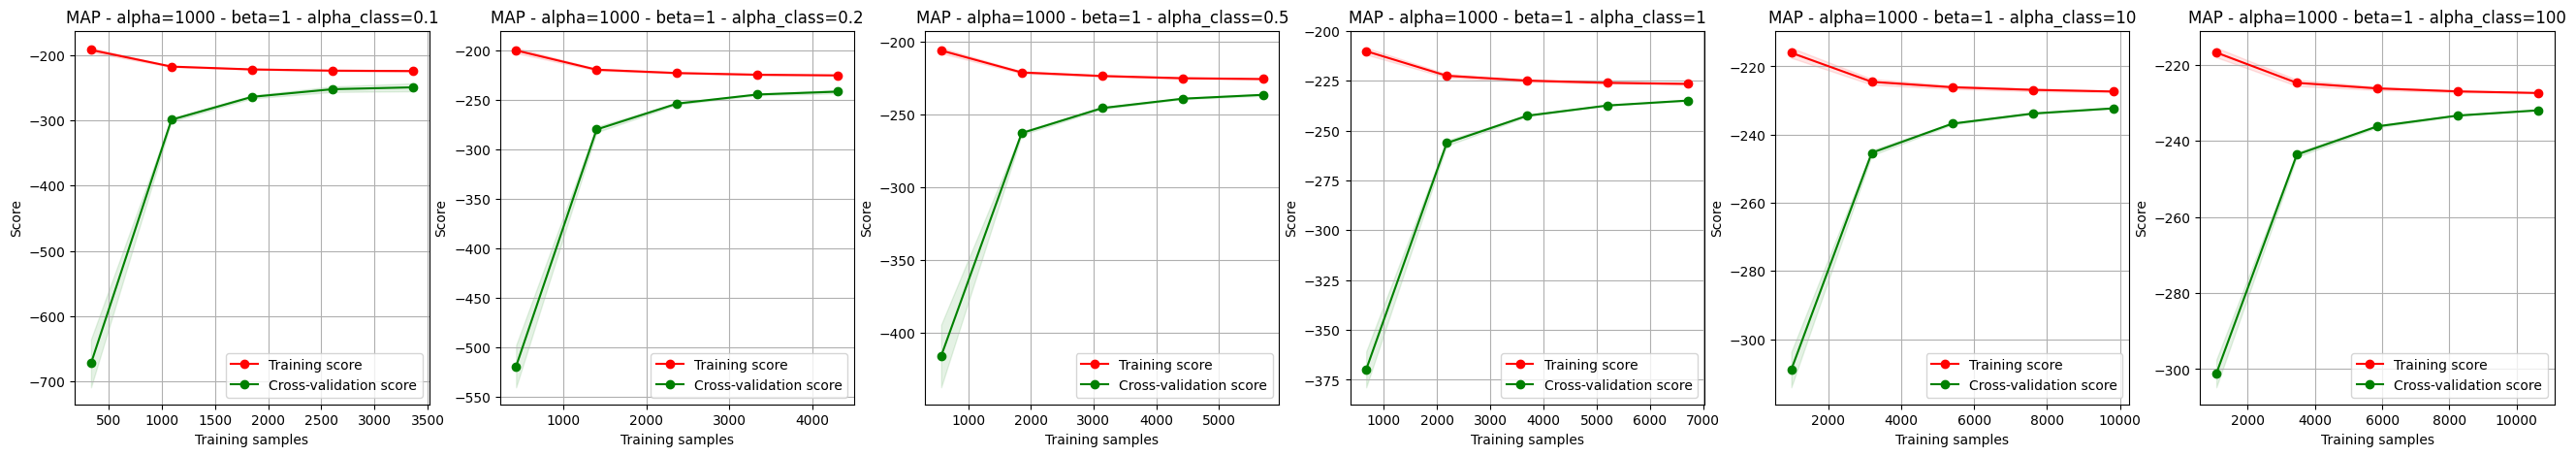

In [15]:
for alpha in [1, 10, 100, 1000]:
    results = get_learning_curve_results(NaiveBayesMAP(alpha=alpha, beta=1), X, y, 12)
    generate_learning_curve_plots(results, title=f"MAP - alpha={alpha} - beta=1")

### Performance comparison with MLE:
Both MLE and MAP perform better overall with increasing `alpha_class` (more and balanced data).
For low values of `alpha` and `beta` (eg: `1`) the performance of MLE and MAP is very similar. 
As we increase `alpha` while keeping `beta=1`, the performace of MAP doesn't change significantly compared to MLE (or other values of `alpha`) indicating that enforcing our prior assumption reagrding class distributions more strongly does not have much of an effect on model performance.

## 4.3 MAP varying Beta 
#### alpha = 1, beta = [1, 1.2, 2, 10, 100] & alpha_class = [0.1, 0.2, 0.5, 1, 10, 100]

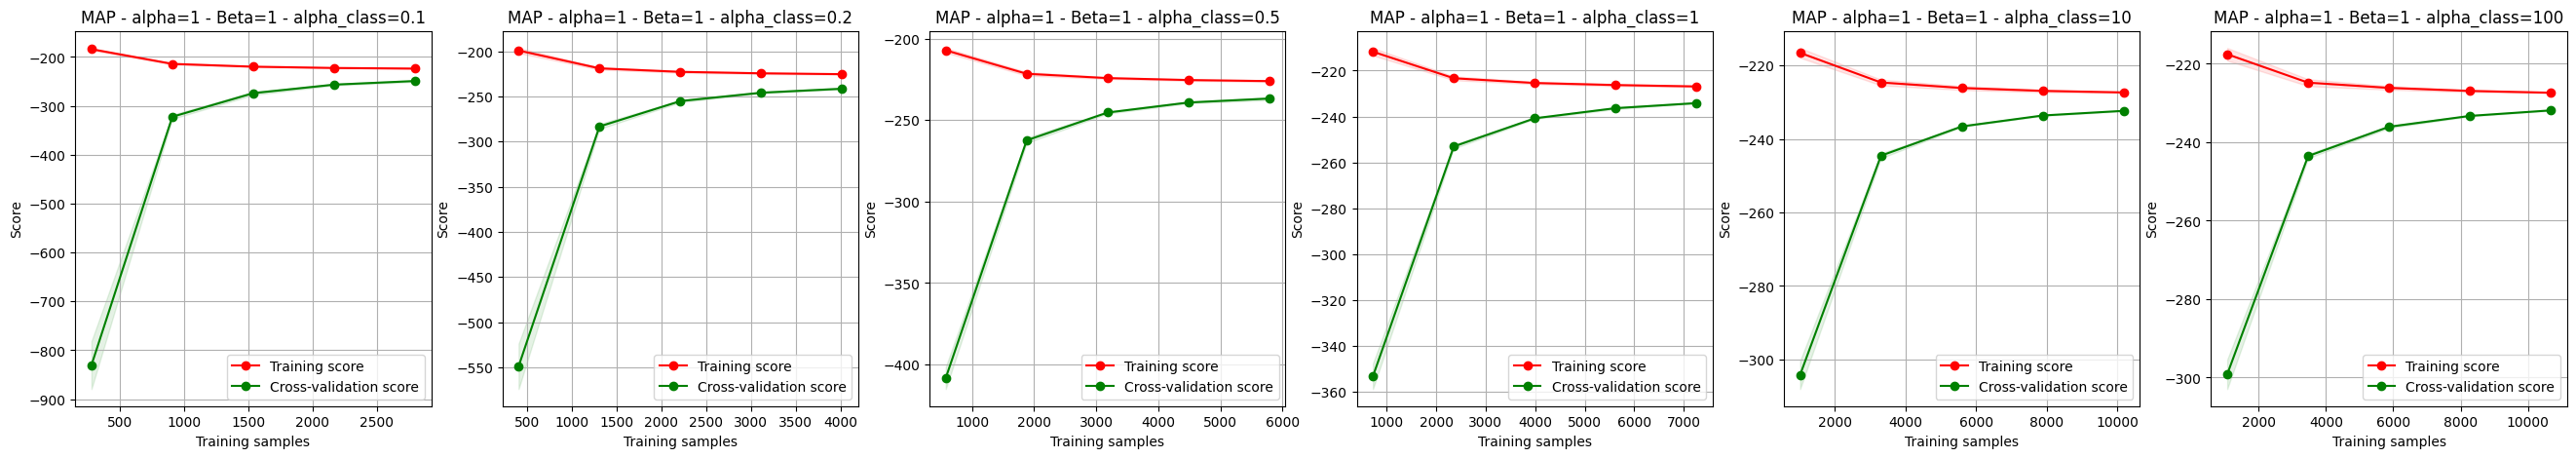

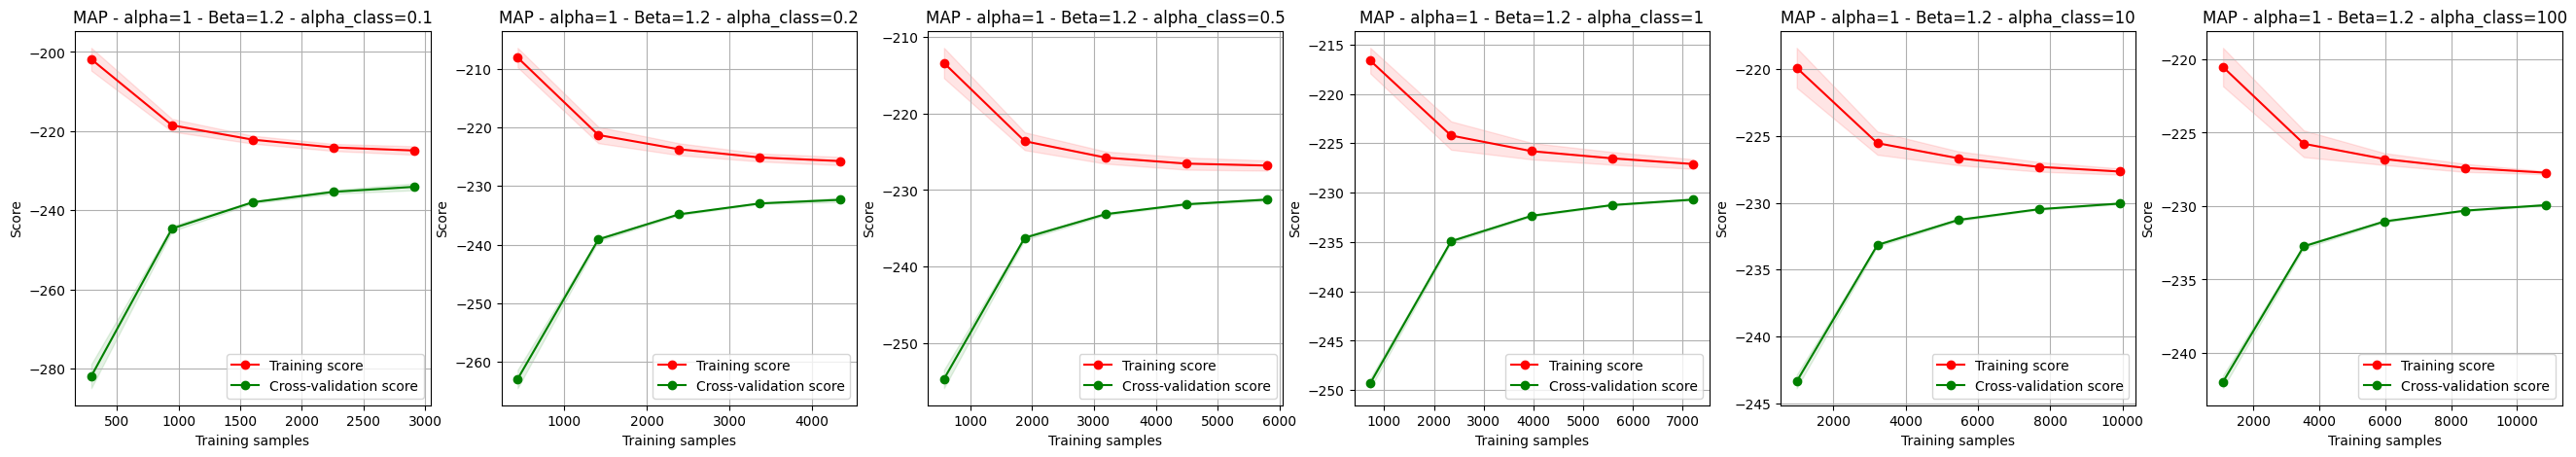

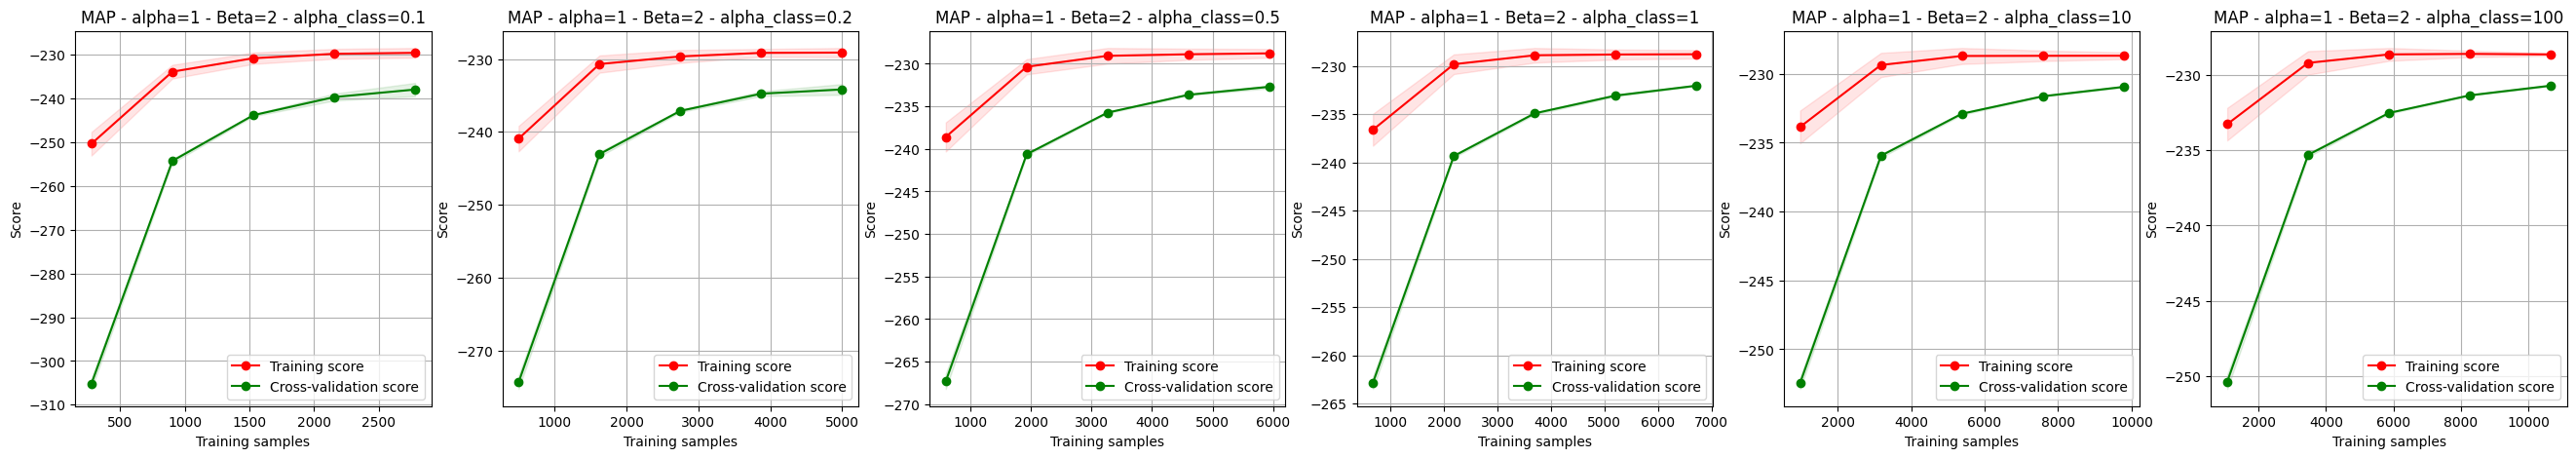

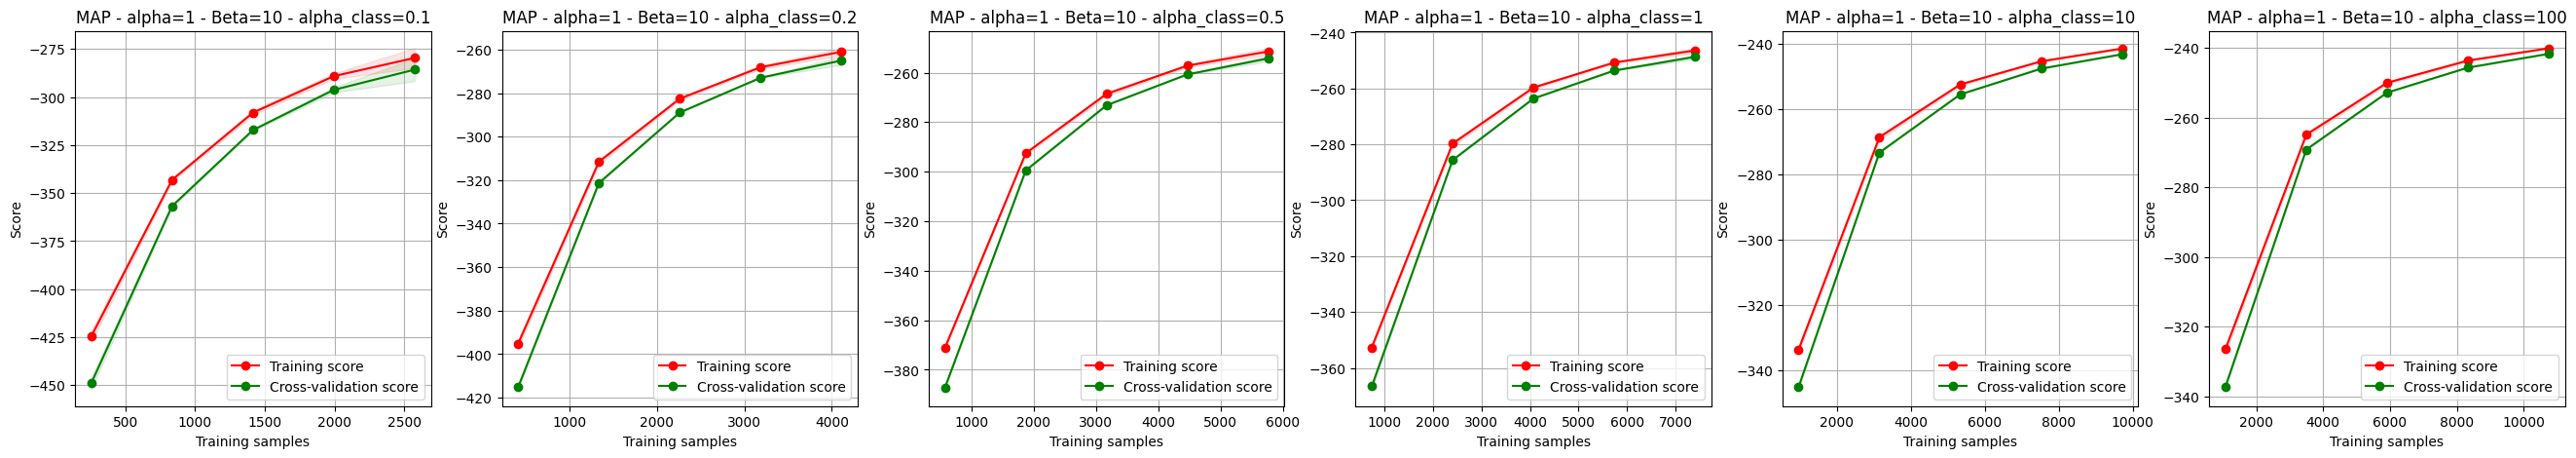

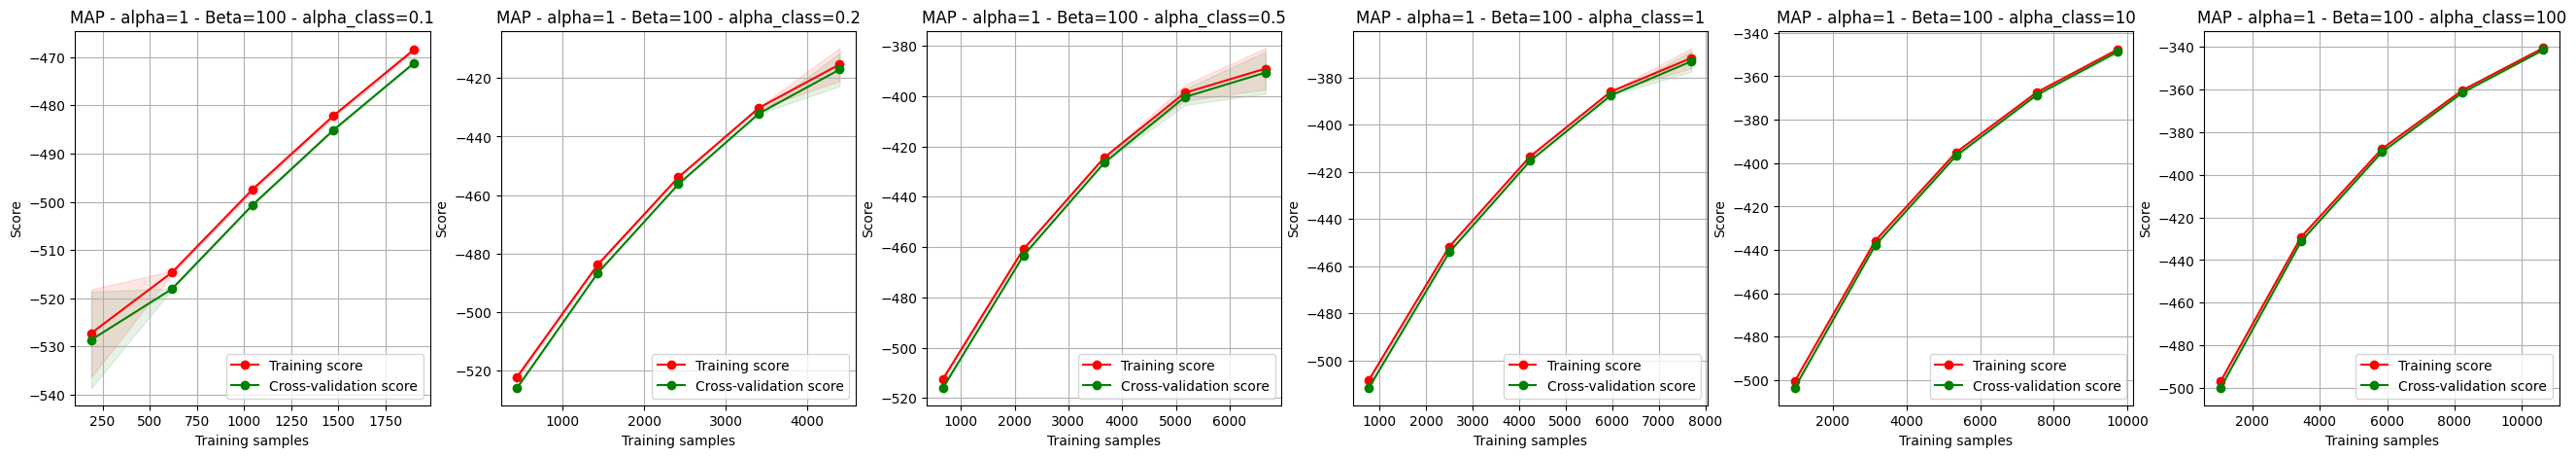

In [16]:
for beta in [1, 1.2, 2, 10, 100]:
    results = get_learning_curve_results(NaiveBayesMAP(alpha=1, beta=beta), X, y, 12)
    generate_learning_curve_plots(results, title=f"MAP - alpha=1 - Beta={beta}")

### Performance comparison with MLE:
Both MLE and MAP perform better overall with increasing `alpha_class` (more and balanced data).
For low values of `alpha` and `beta` (eg: `1`) the performance of MLE and MAP is very similar. 
As we increase `beta`, keeping `alpha=1`, we are more strongly enforcing our prior belief about beta. The performace of MAP decreases compared to MLE (and smaller values of `beta`), indicating that our prior belief regarding the pixel distributions is probably not completely true.

# 5 Discussion
#### 5.1: How does the generalization performance of each model change as a function of the amount of training data and the choice of hyper-parameters?
- As `alpha_class` increases, the amount of training data increases and the data becomes more balanced. 
- We observe a clear trend from the above plots showing that as the value `alpha_class` goes up, the score for cross-validation (green) goes up, indicating better generalization performance. 
- As expected, at `alpha_class=100`, the plots for imbalanced data are nearly identical to the plots for the balanced data since the sampling is nearly balanced.

- MLE takes no hyperparameters, so the generalization performance (cross-validation score) gets better with increasing values of `alpha_class`.
- MAP has two hyperparameters, `alpha` (representing class distribution) and `beta` (representing pixel distribution). 
    - Overall, the generalization performance of MAP gets better with increasing values of `alpha_class`
    - For low values of `alpha` and `beta` (eg: `1`) MAP performs very similarly to MLE.
    - Increasing `alpha` from `1` to `1000` while keeping `beta=1` does not significantly change the generalization performance. 
    - Increasing `beta` from `1` to `100` while keeping `alpha=1` shows a significant decrease (top to bottom in any column in the graphs) in generalization performance, indicating that our prior assumption regarding the pixel distribtion, when enforced strongly, decreases the score and is probably not completely correct.

#### 5.2: Which model would you select for deployment and why?
For model deployment, MAP would be the better choice, since it gives us the ability to change our priors. This ability is valuable since it allows us to experiment with different values of priors, giving us flexibility that MLE cannot match. 
It can also help us validate our prior assumptions w.r.t the problem - if our prior assumptions are wrong, the score will be lower, which can improve our understanding of the priors for similar problems in the future.

